# 프로젝트: 한국어 데이터로 챗봇 만들기 C1 류지호

## Step 1. 데이터 수집 및 전처리 개선

In [7]:
import os
import json
import pandas as pd
import re
from tqdm import tqdm

SESSION_FOLDERS = [
    "/aiffel/AIHUB_KoreanMultiSession/2session",
    "/aiffel/AIHUB_KoreanMultiSession/3session",
    "/aiffel/AIHUB_KoreanMultiSession/4session"
]

json_files = []
for folder in SESSION_FOLDERS:
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))

print(f"발견된 대화파일 수: {len(json_files)}")

dialog_pairs = []
for file in tqdm(json_files, desc="대화파일 파싱"):
    with open(file, encoding='utf-8') as f:
        session = json.load(f)
        # sessionInfo는 리스트(여러 세션)일 수 있음
        session_infos = session.get('sessionInfo', [])
        if not isinstance(session_infos, list):
            session_infos = [session_infos]
        for sess in session_infos:
            dialog = sess.get('dialog', [])
            prev_speaker, prev_text = None, None
            for turn in dialog:
                speaker = turn.get('speaker')
                text = turn.get('utterance')
                if text is None or speaker is None:
                    continue
                text = text.strip()
                if prev_speaker is not None and prev_speaker != speaker:
                    dialog_pairs.append({'Q': prev_text, 'A': text})
                prev_speaker, prev_text = speaker, text

print(f"총 Q/A 쌍: {len(dialog_pairs)}")

df = pd.DataFrame(dialog_pairs)
df = df.dropna().reset_index(drop=True)
df.to_csv("multi_session_qa.csv", index=False)
print(df.head())

def preprocess_korean_text(sentence):
    sentence = sentence.strip()
    sentence = re.sub(r'[ㅋ]{2,}', 'ㅋㅋ', sentence)
    sentence = re.sub(r'[ㅎ]{2,}', 'ㅎㅎ', sentence)
    sentence = re.sub(r'[ㅜㅠ]{2,}', 'ㅜㅜ', sentence)
    sentence = re.sub(r'[ㅡ]{2,}', 'ㅡㅡ', sentence)
    sentence = re.sub(r'https?://\S+|www\.\S+', '[URL]', sentence)
    sentence = re.sub(r'\S+@\S+', '[EMAIL]', sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,~]+", " ", sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.strip()
    slang_dict = {'갑툭튀': '갑자기 툭 튀어나온', '꾸안꾸': '꾸민 듯 안 꾸민 듯'}
    for slang, meaning in slang_dict.items():
        sentence = sentence.replace(slang, meaning)
    return sentence

if not df.empty:
    df['Q_processed'] = df['Q'].apply(preprocess_korean_text)
    df['A_processed'] = df['A'].apply(preprocess_korean_text)
    df.to_csv("multi_session_qa_preprocessed.csv", index=False)
    print(df[['Q_processed', 'A_processed']].head())
else:
    print("Q/A 데이터가 없습니다. 폴더/파일/구조를 다시 확인하세요.")

발견된 대화파일 수: 100


대화파일 파싱: 100%|██████████| 100/100 [00:00<00:00, 1127.41it/s]

총 Q/A 쌍: 3596
                                                   Q  \
0              관광 지명에 대한 이해를 높이던 중에 궁금한 점이 생겨서 찾아왔어.   
1                            네. 안녕하세요. 어떤 것이 궁금하신가요?   
2                                 원주 거돈사지에 대해 알고 싶어!   
3  원주 거돈사지(原州 居頓寺址)는 강원특별자치도 원주시 부론면, 현계산 기슭의 작은 ...   
4                       오! 절터였구나. 나는 절 특유의 분위기를 좋아해!   

                                                   A  
0                            네. 안녕하세요. 어떤 것이 궁금하신가요?  
1                                 원주 거돈사지에 대해 알고 싶어!  
2  원주 거돈사지(原州 居頓寺址)는 강원특별자치도 원주시 부론면, 현계산 기슭의 작은 ...  
3                       오! 절터였구나. 나는 절 특유의 분위기를 좋아해!  
4                   맞아요. 절에 가면 마음이 잔잔해지고, 마음이 평안해지죠.  


                                         Q_processed  \
0             관광 지명에 대한 이해를 높이던 중에 궁금한 점이 생겨서 찾아왔어 .   
1                         네 . 안녕하세요 . 어떤 것이 궁금하신가요 ?   
2                                원주 거돈사지에 대해 알고 싶어 !   
3  원주 거돈사지 는 강원특별자치도 원주시 부론면 , 현계산 기슭의 작은 골짜기를 끼고...   
4                    오 ! 절터였구나 . 나는 절 특유의 분위기를 좋아해 !   

                                         A_processed  
0                         네 . 안녕하세요 . 어떤 것이 궁금하신가요 ?  
1                                원주 거돈사지에 대해 알고 싶어 !  
2  원주 거돈사지 는 강원특별자치도 원주시 부론면 , 현계산 기슭의 작은 골짜기를 끼고...  
3                    오 ! 절터였구나 . 나는 절 특유의 분위기를 좋아해 !  
4                맞아요 . 절에 가면 마음이 잔잔해지고 , 마음이 평안해지죠 .  


## Step 2. 데이터 증강 및 토큰화 개선

In [8]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import numpy as np

df = pd.read_csv("multi_session_qa_preprocessed.csv")
questions = df["Q_processed"].astype(str).tolist()
answers = df["A_processed"].astype(str).tolist()

from konlpy.tag import Mecab, Okt
try:
    mecab = Mecab()
    morpheme_analyzer = mecab
except:
    morpheme_analyzer = Okt()

def enhanced_morpheme_tokenize(sentence):
    try:
        return ' '.join(morpheme_analyzer.morphs(sentence))
    except:
        return sentence

questions_morpheme = [enhanced_morpheme_tokenize(q) for q in questions]
answers_morpheme = [enhanced_morpheme_tokenize(a) for a in answers]

augmented_questions = questions_morpheme.copy()
augmented_answers = answers_morpheme.copy()
for i in range(len(questions_morpheme)):
    if len(questions_morpheme[i].split()) > 3:
        augmented_questions.append(answers_morpheme[i])
        augmented_answers.append(questions_morpheme[i])

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    augmented_questions + augmented_answers, target_vocab_size=2**14)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

MAX_LENGTH = 50
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for q, a in zip(inputs, outputs):
        q_tok = START_TOKEN + tokenizer.encode(q) + END_TOKEN
        a_tok = START_TOKEN + tokenizer.encode(a) + END_TOKEN
        if len(q_tok) <= MAX_LENGTH and len(a_tok) <= MAX_LENGTH:
            tokenized_inputs.append(q_tok + [0]*(MAX_LENGTH-len(q_tok)))
            tokenized_outputs.append(a_tok + [0]*(MAX_LENGTH-len(a_tok)))
    return np.array(tokenized_inputs), np.array(tokenized_outputs)

questions_tokenized, answers_tokenized = tokenize_and_filter(augmented_questions, augmented_answers)
np.save('questions_tokenized.npy', questions_tokenized)
np.save('answers_tokenized.npy', answers_tokenized)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"토큰화된 질문 shape: {questions_tokenized.shape}")
print(f"토큰화된 답변 shape: {answers_tokenized.shape}")
print(f"단어장 크기: {VOCAB_SIZE}")

토큰화된 질문 shape: (6584, 50)
토큰화된 답변 shape: (6584, 50)
단어장 크기: 6744


## Step 3. 모델 아키텍처 개선

In [10]:
import tensorflow as tf
import numpy as np
import os
import json
import logging

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

# 스케일드 닷 프로덕트 어텐션 함수 (개선: 어텐션 가중치 반환)
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
    
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

# 멀티헤드 어텐션 레이어 (개선: 어텐션 가중치 반환 추가)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model
        })
        return config

# 패딩 마스크 생성 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 개선된 인코더 레이어 (드롭아웃 비율 조정 가능)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 인코더 (임베딩 레이어 분리)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 디코더의 층.
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 맥락 인식 강화 인코더 (메모리 네트워크 추가)
def context_aware_encoder(vocab_size,
                         num_layers,
                         units,
                         d_model,
                         num_heads,
                         dropout,
                         memory_size=64,
                         name="context_aware_encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 기본 인코더 처리
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 맥락 메모리 초기화 (배치 크기에 맞게 확장)
    batch_size = tf.shape(inputs)[0]
    memory = tf.zeros((batch_size, memory_size, d_model))
    
    # 인코더 레이어 처리 (맥락 메모리 활용)
    for i in range(num_layers):
        # 기본 인코더 레이어 처리
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
        # 맥락 메모리 업데이트 (현재 출력과 메모리 결합)
        if i < num_layers - 1:  # 마지막 레이어 제외
            # 현재 출력의 평균을 메모리에 추가
            avg_output = tf.reduce_mean(outputs, axis=1, keepdims=True)
            memory = tf.concat([memory[:, 1:, :], avg_output], axis=1)
            
            # 메모리와 현재 출력 결합
            memory_attention = MultiHeadAttention(
                d_model, num_heads, name=f"memory_attention_{i}")({
                    'query': outputs,
                    'key': memory,
                    'value': memory,
                    'mask': None  # 메모리에는 마스크 필요 없음
                })
            
            # 메모리 어텐션 결과와 현재 출력 결합
            outputs = tf.keras.layers.LayerNormalization(
                epsilon=1e-6)(outputs + memory_attention)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 한국어 특화 디코더 (게이트 메커니즘 추가)
def korean_decoder(vocab_size,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  name="korean_decoder"):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 이전 레이어의 출력을 저장할 리스트
    layer_outputs = [outputs]
    
    # num_layers만큼 쌓아올린 디코더의 층.
    for i in range(num_layers):
        # 기본 디코더 레이어 처리
        current_outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
        # 게이트 메커니즘 (이전 레이어 출력과 현재 레이어 출력 결합)
        if i > 0:  # 첫 번째 레이어 제외
            # 게이트 값 계산
            gate = tf.keras.layers.Dense(
                d_model, activation='sigmoid', name=f'gate_{i}')(
                    tf.concat([outputs, current_outputs], axis=-1))
            
            # 게이트를 사용하여 이전 출력과 현재 출력 결합
            outputs = gate * current_outputs + (1 - gate) * outputs
        else:
            outputs = current_outputs
        
        # 현재 레이어 출력 저장
        layer_outputs.append(outputs)
    
    # 모든 레이어의 출력을 결합 (잔차 연결)
    all_outputs = tf.concat(layer_outputs, axis=-1)
    final_outputs = tf.keras.layers.Dense(d_model, activation='relu')(all_outputs)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=final_outputs,
        name=name)

# 개선된 트랜스포머 모델 (맥락 인식 및 한국어 특화)
def improved_transformer(vocab_size, num_layers, units, d_model, num_heads, dropout):
    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더의 룩어헤드 마스크(첫번째 서브레이어)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 디코더의 패딩 마스크(두번째 서브레이어)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더 출력
    enc_outputs = context_aware_encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    # 디코더 출력
    dec_outputs = korean_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층을 통과시켜 단어 예측
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name="improved_transformer")

# 모델 생성 및 테스트 (예시)
if __name__ == "__main__":
    # 모델 하이퍼파라미터
    VOCAB_SIZE = 12000  # 실제 토크나이저에 맞게 조정 필요
    NUM_LAYERS = 6
    D_MODEL = 512
    NUM_HEADS = 8
    UNITS = 2048
    DROPOUT = 0.1
    
    # 모델 생성
    model = improved_transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )
    
    # 모델 요약 정보 출력
    model.summary()
    
    # 모델 구조 시각화 (옵션)
    try:
        tf.keras.utils.plot_model(
            model,
            to_file='improved_transformer_model.png',
            show_shapes=True,
            show_layer_names=True,
            expand_nested=True
        )
        print("모델 구조 이미지가 저장되었습니다.")
    except Exception as e:
        print(f"모델 구조 시각화 실패: {e}")

Model: "improved_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
context_aware_encoder (Function (None, None, 512)    30316544    inputs[0][0]                     
                                                                 enc_padding_ma

## Step 4. 모델 학습 및 평가 개선

Epoch 1/30
93/93 [==============================] - 71s 523ms/step - loss: 3.4752 - accuracy: 0.0349 - val_loss: 3.2455 - val_accuracy: 0.0672

Epoch 00001: val_loss improved from inf to 3.24552, saving model to ./checkpoints/transformer/cp-0001.ckpt
Epoch 2/30
93/93 [==============================] - 46s 491ms/step - loss: 2.6587 - accuracy: 0.0849 - val_loss: 2.7962 - val_accuracy: 0.0998

Epoch 00002: val_loss improved from 3.24552 to 2.79619, saving model to ./checkpoints/transformer/cp-0002.ckpt
Epoch 3/30
93/93 [==============================] - 46s 489ms/step - loss: 2.2899 - accuracy: 0.1105 - val_loss: 2.5223 - val_accuracy: 0.1151

Epoch 00003: val_loss improved from 2.79619 to 2.52231, saving model to ./checkpoints/transformer/cp-0003.ckpt
Epoch 4/30
93/93 [==============================] - 46s 490ms/step - loss: 2.0529 - accuracy: 0.1276 - val_loss: 2.3350 - val_accuracy: 0.1317

Epoch 00004: val_loss improved from 2.52231 to 2.33502, saving model to ./checkpoints/transform

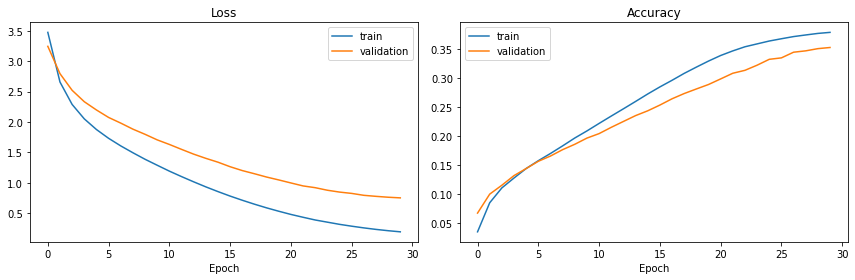

모델이 ./checkpoints/transformer/final_model에 저장되었습니다.


In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_size = int(0.9 * len(questions_tokenized))
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': train_questions, 'dec_inputs': train_answers[:, :-1]},
    {'outputs': train_answers[:, 1:]}
)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': val_questions, 'dec_inputs': val_answers[:, :-1]},
    {'outputs': val_answers[:, 1:]}
)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def weighted_loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    weighted_mask = tf.where(mask > 0, 1.2 * mask, mask)
    loss = tf.multiply(loss, weighted_mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=weighted_loss_function,
    metrics=[accuracy]
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_dir = "./checkpoints/transformer"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True, monitor='val_loss')

EPOCHS = 30
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, cp_callback],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

final_model_path = os.path.join(checkpoint_dir, "final_model")
model.save_weights(final_model_path)
print(f"모델이 {final_model_path}에 저장되었습니다.")

## Step 5. 추론 및 대화 인터페이스 개선

In [ ]:
# 먼저 모델과 토크나이저를 로드합니다
import pickle
import tensorflow as tf
import numpy as np

# 토크나이저 로드
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# 모델 하이퍼파라미터 설정 (훈련에 사용된 것과 동일해야 함)
VOCAB_SIZE = tokenizer.vocab_size + 2  # start, end 토큰 포함
NUM_LAYERS = 6
D_MODEL = 512
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.1
MAX_LENGTH = 50

# 모델 재생성
from improved_transformer import improved_transformer  # 모델 정의가 있는 파일을 import

model = improved_transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

# 저장된 가중치 로드
model.load_weights("./checkpoints/transformer/final_model")


class KoreanChatbotSession:
    def __init__(self, model, tokenizer, max_length=50, context_turns=3):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.vocab_size
        self.end_token = tokenizer.vocab_size + 1
        self.context = []
        self.context_turns = context_turns
    
    def reset_context(self):
        self.context = []
    
    def build_context_input(self, user_input):
        context_text = ""
        for turn in self.context[-self.context_turns*2:]:
            prefix = "사용자: " if turn['user']=='user' else "챗봇: "
            context_text += f"{prefix}{turn['text']}\n"
        context_text += f"사용자: {user_input}\n챗봇: "
        return context_text.strip()
    
    def preprocess_input(self, text):
        tokens = [self.start_token] + self.tokenizer.encode(text) + [self.end_token]
        tokens = tokens[:self.max_length] + [0]*(self.max_length-len(tokens[:self.max_length]))
        return tf.expand_dims(tokens, 0)
    
    def generate_response(self, user_input, temperature=0.7, max_length=50):
        try:
            context_input = self.build_context_input(user_input)
            encoder_input = self.preprocess_input(context_input)
            decoder_input = tf.expand_dims([self.start_token], 0)
            
            # 수정된 부분: * 대신 i 사용
            for i in range(max_length):
                preds = self.model([encoder_input, decoder_input], training=False)
                preds = preds[:, -1, :] / temperature
                pred_id = tf.random.categorical(preds, 1)[0,0].numpy()
                
                if pred_id == self.end_token:
                    break
                
                decoder_input = tf.concat([decoder_input, tf.expand_dims([pred_id], 0)], axis=-1)
            
            output_tokens = [int(i) for i in decoder_input[0].numpy()]
            if output_tokens[0] == self.start_token:
                output_tokens = output_tokens[1:]
            if self.end_token in output_tokens:
                output_tokens = output_tokens[:output_tokens.index(self.end_token)]
            
            output_text = self.tokenizer.decode(output_tokens)
            self.context.append({'user':'user','text':user_input})
            self.context.append({'user':'bot','text':output_text})
            return output_text
        except Exception as e:
            print(f"응답 생성 중 오류 발생: {e}")
            return "죄송합니다, 응답을 생성하는 데 문제가 발생했습니다."


def run_chatbot_cli(model, tokenizer):
    print("모델을 초기화하는 중...")
    session = KoreanChatbotSession(model, tokenizer)
    print("ChatGBT입니다. '종료' 입력 시 종료.")
    while True:
        user_input = input("사용자: ").strip()
        if user_input.lower() in ['종료', 'quit', 'exit']:
            print("챗봇 세션 종료.")
            break
        elif user_input.lower() in ['새로시작', 'reset', 'restart']:
            session.reset_context()
            print("대화 맥락이 초기화되었습니다.")
            continue
        elif not user_input:
            continue
        print("챗봇:", session.generate_response(user_input))

In [ ]:
run_chatbot_cli(model, tokenizer)